<h1>Tera - Desafio de interpretação e predição do valor de venda de imóveis</h1>

Esse código apresenta uma resolução para o desafio de regressão proposto pela Tera. O conjunto de dados descreve a venda de propriedades residenciais individuais de uma cidade americana, de 2006 a 2010. Ao todo são 2.930 observações e um grande número de features (23 nominais, 23 ordinais, 14 discretas e 20 contínuas) envolvidas na avaliação do valor dos imóveis, ou seja, são 80 variáveis explicativas.

O trabalho ao longo desse código foca, primeiro, em fazer uma análise exploratória dos dados e feature engeneering para organização ou manutenção das variáveis. Depois, são apresentadas leituras realizadas a partir da criação de um modelo de regressão linear e de um modelo de Machine Learning utilizando o algoritmo RandomForest.

Grandes agradecimentos à equipe da Tera, em especial ao expert Marcus Oliveira, que foi de grande ajuda na solução do problema.

<h2>1. Configurações iniciais</h2>

<h3>1.1 Importação das bibliotecas que serão utilizas ao longo do código</h3>

In [1]:
#Core
import numpy as np
import pandas as pd
from typing import List, Tuple
import math

#Plot
import matplotlib.pyplot as plt 
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns

from sklearn.model_selection import train_test_split 


#Estatística - Modelo de interpretação
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api         as sm
import statsmodels.formula.api as smf

#Criação do modelo de Machine Learning
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer
from category_encoders.target_encoder import TargetEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.inspection import permutation_importance

<h3>1.2 Elaboração de algumas funções utilizadas posteriormente no código</h3>

In [40]:
#Funções utilizadas ao longo do código


#Calcula o VIF para identificar multicolinearidade
def calc_vif(dataframe):
    vif = pd.DataFrame()
    vif['variables'] = dataframe.columns
    vif['VIF'] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return(vif)

def plot_vif(vif):
    print('vars: ', list(vif.columns))
    print('Variable Inflation Factors:', vif.VIF.sum(), '\n')

def train_test_valid_split(
    df: pd.DataFrame,
    features: list,
    target: str,
    test_size: float,
    valid_size: float,
    random_state: int,
) -> Tuple[np.array, np.array, np.array, np.array, np.array, np.array]:
    """Splits dataframe in training, testing and validation sets"""

    # The first train/test split
    (X_train, X_test, y_train, y_test) = train_test_split(
        df[features],
        df[target],
        test_size=test_size,
        random_state=random_state,
    )

    # The second train/test split
    (X_test, X_val, y_test, y_val) = train_test_split(
        X_test, y_test, test_size=valid_size, random_state=random_state
    )

    return X_train, X_test, X_val, y_train, y_test, y_val

def metrics_report(y, y_pred, dataset_name='valid'):
  mean_y = np.mean(y)
  mean_pred = np.mean(y_pred)

  rmse = round(math.sqrt(mean_squared_error(y, y_pred)), 2)
  mae = mean_absolute_error(y, y_pred)
  r2 = r2_score(y, y_pred)
  mape = mean_absolute_percentage_error(y, y_pred)
  
  report = pd.DataFrame({
    'metric': ['RMSE', 'MAE', 'R^2', 'MAPE', 'Avg. target', 'Avg. Prediction'],
    dataset_name: [rmse, mae, r2, mape, mean_y, mean_pred]
  })

  report[dataset_name] = report[dataset_name].round(2)
  return report




In [3]:
#base original
base = pd.read_csv('base.csv', skipinitialspace=True)

<h2>2. EDA da base original</h2>

In [1]:
#Verificando as informações sobre nulos e tipo de cada coluna no dataframe
base.info(verbose=True)

NameError: name 'base' is not defined

<h4>2.1 Anotação da variável resposta e das features numéricas e categóricas (cardinais e ordinais)</h4>

In [5]:
#Variável resposta
v_resposta = 'PrecoVenda'

#Lista das variáveis numéricas
v_numericos = base.select_dtypes(include=["int", "float"]).columns.to_list()
v_numericos.remove(v_resposta)
v_numericos.remove('ClasseImovel')

#Lista das variáveis categóricas
v_categoricas = base.select_dtypes(exclude=["int", "float"]).columns.to_list()
v_categoricas.append('ClasseImovel')

#Distinção das variáveis categóricas
cat_ordinal = ['FormaProp', 'Servicos', 'InclinacaoLote', 'Qualidade', 'Condicao', 'QualidadeCobertura', 'CondicaoExterna', 'AlturaPorao', 'CondicaoPorao', 'ParedePorao', 'TipoAcabPorao1', 'TipoAcabPorao2', 'QualidadeAquecimento', 'QualidadeCozinha', 'QualdiadeLareira', 'AcabamentoGaragem', 'QualidadeGaragem', 'CondicaoGaragem', 'EntradaPavimentada']

cat_cardinal = [x for x in v_categoricas if x not in cat_ordinal]


<h4>2.2 Entendendo a distribuição da variável resposta</h4>

A versão original da variável resposta é comparada a uma versão com tratamento logaritmico. Percebe-se que a variável em base logaritmica possui distribuição mais próxima à normal, logo, é a mais correta para o trabalho no modelo de interpretação por regressão linear

In [6]:
#Criando uma variável com o log dos preços para verificar diferenças entre a distribuição da variável em forma comum e logarítimica 
base['logPrecoVenda'] = np.log(base['PrecoVenda'])

#Verificando graficamente a distribuição das variáveis
fig = make_subplots(rows= 2, cols=2, subplot_titles=["Distribuição da variável PrecoVenda", "Distribuição da variável logPrecoVenda", "Area Contruida x Preço de Venda", "Área construída x log Preço de Venda"])

fig.add_trace(go.Histogram(x = base['PrecoVenda']), row=1,col=1)
fig.add_trace(go.Histogram(x = base['logPrecoVenda']), row=1, col=2)
fig.add_trace(go.Scatter(x=base['PrecoVenda'], y=base['AreaConstruida'], mode='markers', showlegend=True), row=2, col=1)
fig.add_trace(go.Scatter(x=base['logPrecoVenda'], y=base['AreaConstruida'], mode='markers'), row=2, col=2)


fig.update_layout(width=1200, height=600)
fig.update_yaxes(title_text=('Teste1', 'Teste1', 'Teste1', 'Teste1'), row=(1,1,2,2), col=(1,2,1,2))
fig.show()



<h4>2.3 Variáveis categóricas: Examinando relações entre as categorias e alterações no valor das residências</h4>

São criados gráficos violinos de todas as variáveis para entender quais dessas têm diferenciações mais significativas entre o conjunto das respostas e podem indicar uma diferenciação maior nos modelos. A diferenciação entre cardinais e ordinais nesse caso foi realizada para facilitar a visualização dos gráficos

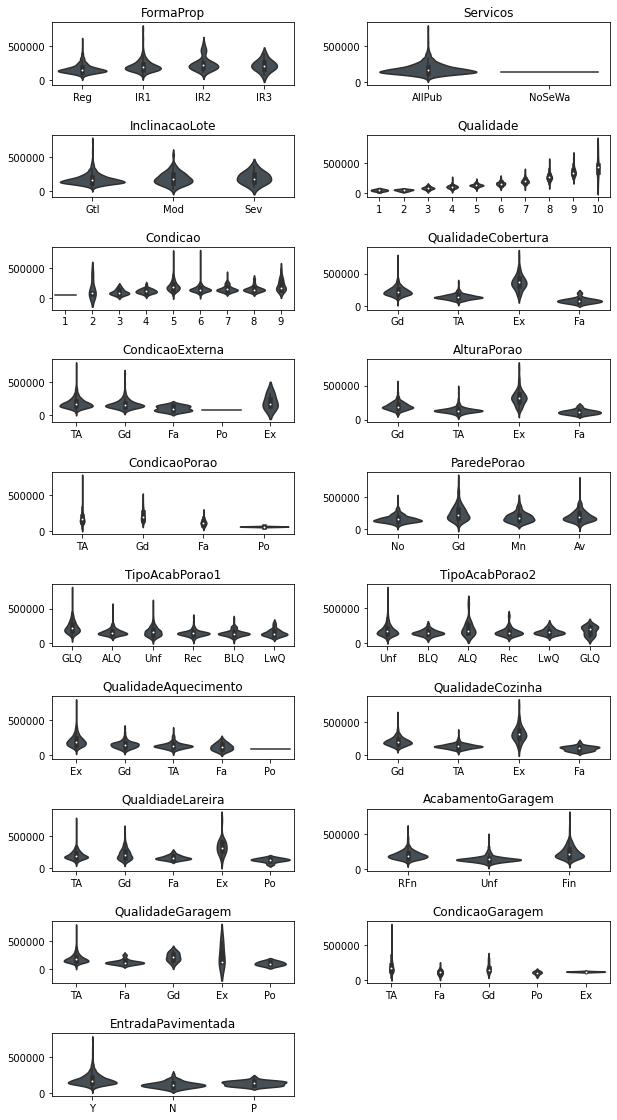

In [7]:
#Area de figura
fig = plt.figure(figsize=(10,90))
fig.subplots_adjust(hspace=0.8, wspace=0.3)
total_plots = len(v_categoricas)
i = 0

#Iteração nas variáveis categóricas ordinais
for var in cat_ordinal:
    ax = fig.add_subplot(total_plots, 2, i+1)

    sns.violinplot(x=var, y=v_resposta, data=base, ax=ax, color='#435058')
    ax.set_title(var)
    ax.set_ylabel('')
    ax.set_xlabel('')
    i += 1


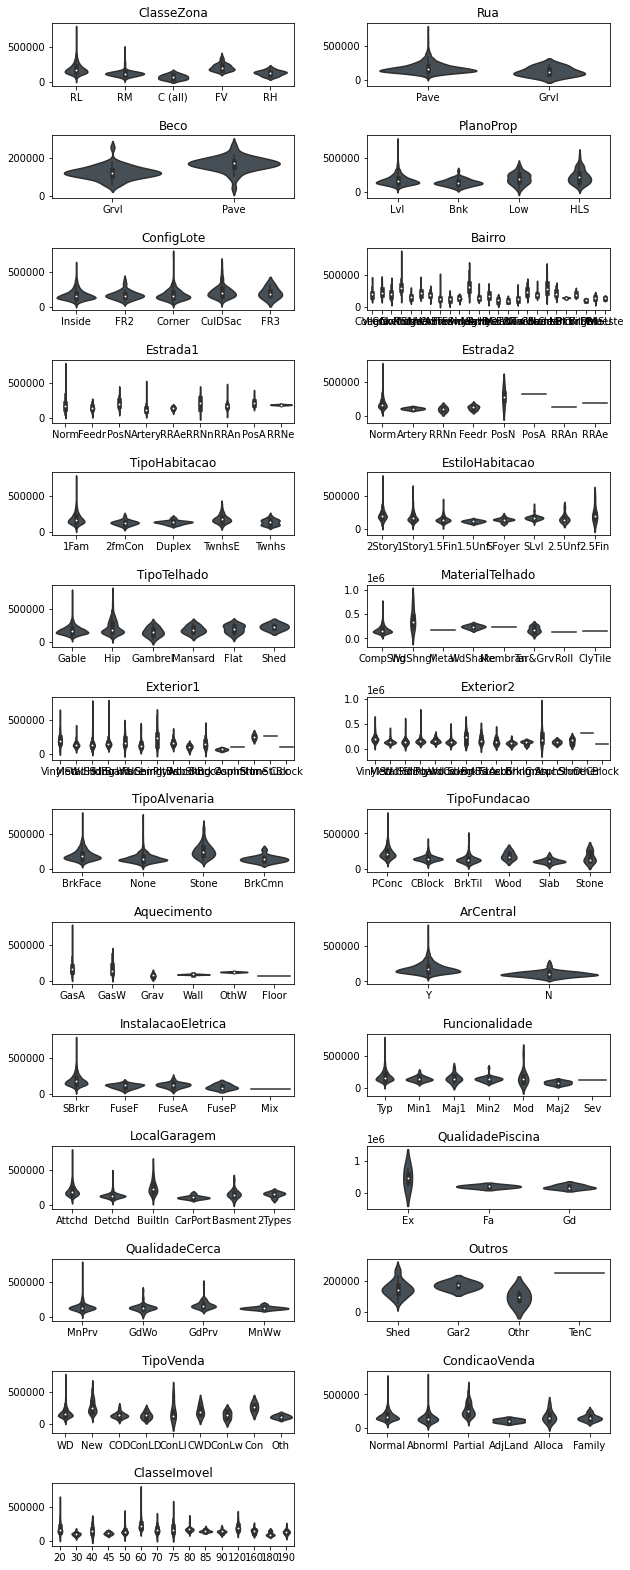

In [8]:
#Area de figura
fig = plt.figure(figsize=(10,90))
fig.subplots_adjust(hspace=0.8, wspace=0.3)
total_plots = len(v_categoricas)
i = 0

#Iteração nas variáveis categóricas cardinais
for var in cat_cardinal:
    ax = fig.add_subplot(total_plots, 2, i+1)

    sns.violinplot(x=var, y=v_resposta, data=base, ax=ax, color='#435058')
    ax.set_title(var)
    ax.set_ylabel('')
    ax.set_xlabel('')
    i += 1

In [9]:
#Verificando o grau de cardinalidade das variáveis categóricas
base[v_categoricas].nunique().sort_values(ascending=False)

Bairro                  25
Exterior2               16
ClasseImovel            15
Exterior1               15
Estrada1                 9
TipoVenda                9
MaterialTelhado          8
EstiloHabitacao          8
Estrada2                 8
Funcionalidade           7
TipoAcabPorao1           6
LocalGaragem             6
TipoTelhado              6
CondicaoVenda            6
Aquecimento              6
TipoFundacao             6
TipoAcabPorao2           6
QualdiadeLareira         5
QualidadeGaragem         5
CondicaoGaragem          5
InstalacaoEletrica       5
QualidadeAquecimento     5
ClasseZona               5
ConfigLote               5
TipoHabitacao            5
CondicaoExterna          5
FormaProp                4
Outros                   4
QualidadeCerca           4
PlanoProp                4
ParedePorao              4
QualidadeCozinha         4
TipoAlvenaria            4
QualidadeCobertura       4
AlturaPorao              4
CondicaoPorao            4
InclinacaoLote           3
A

<h2>3. Feature Engineering</h2>

<h4>3.1 Removendo Nulos</h4>

São removidas variáveis com valores muito altos de inputs nulos. Os dados nulos de outras variáveis são inputados a partir da mediana do conjunto para valores numéricos ou do input mais frequente para valores categóricos

In [10]:
base_corrigida = base.drop(['QualidadePiscina', 'Outros', 'Beco', 'QualidadeCerca', 'QualdiadeLareira'], axis=1)
nulos_categoricas = []
nulos_numericas = []

for col in base_corrigida:
    if base_corrigida[col].isna().sum() != 0:
        print('{}: {} nulos'.format(col,base_corrigida[col].isna().sum()))
        if base_corrigida[col].dtype == 'float64':
            nulos_numericas.append(col)
        else:
            nulos_categoricas.append(col)

Fachada: 259 nulos
TipoAlvenaria: 8 nulos
AreaAlvenaria: 8 nulos
AlturaPorao: 37 nulos
CondicaoPorao: 37 nulos
ParedePorao: 38 nulos
TipoAcabPorao1: 37 nulos
TipoAcabPorao2: 38 nulos
InstalacaoEletrica: 1 nulos
LocalGaragem: 81 nulos
AnoGaragem: 81 nulos
AcabamentoGaragem: 81 nulos
QualidadeGaragem: 81 nulos
CondicaoGaragem: 81 nulos


In [12]:

#Criando os recortes
x1 = base_corrigida[nulos_numericas] 
x2 = base_corrigida[nulos_categoricas]

#Criando os inputers
mascara1 = SimpleImputer(missing_values=np.nan, strategy='median')
mascara2 = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
mascara1 = mascara1.fit(x1)
mascara2 = mascara2.fit(x2)

#Substituindo os valores nulos do recorte pelos inputers
base_corrigida[nulos_numericas] = mascara1.transform(x1) 
base_corrigida[nulos_categoricas] = mascara2.transform(x2)

<h4>3.2 Removendo colunas categóricas com alta cardinalidade</h4>

Optou-se pela remoção das colunas alta cardinalidade ou sem interpretação interessante apenas para simplificação da leitura dos modelos posteriores. Outras situações situações podem pedir o agrupamento dessas variáveis ou outro tipo de trabalho.

In [14]:
base_corrigida = base_corrigida.drop(['Bairro','Exterior1','Exterior2','ClasseImovel','Funcionalidade', 'Estrada1', 'Estrada2', 'MesVenda', 'ValorOutros'], axis=1)

Optei trabalhar apenas com imóveis vendidos sob condição normal, uma vez que são os mais recorrentes e interessante para a análise. Além disso, imóveis vendidos sob outras condições podem distorcer a análise significativamente

In [15]:
base_corrigida = base_corrigida.query("CondicaoVenda == 'Normal'")
base_corrigida.drop('CondicaoVenda', axis=1)

,Id,ClasseZona,Fachada,TamanhoLote,Rua,FormaProp,PlanoProp,Servicos,ConfigLote,InclinacaoLote,...,AreaDeck,AreaVarandaAberta,AreaVarandaFechada,AreaVaranda3Estacoes,AreaAlpendre,AreaPiscina,AnoVenda,TipoVenda,PrecoVenda,logPrecoVenda
0,1,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,61,0,0,0,0,2008,WD,208500,12.247694
1,2,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,298,0,0,0,0,0,2007,WD,181500,12.109011
2,3,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,42,0,0,0,0,2008,WD,223500,12.317167
4,5,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,192,84,0,0,0,0,2008,WD,250000,12.429216
5,6,RL,85.0,14115,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,40,30,0,320,0,0,2009,WD,143000,11.870600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,40,0,0,0,0,2007,WD,175000,12.072541
1456,1457,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,349,0,0,0,0,0,2010,WD,210000,12.254863
1457,1458,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,60,0,0,0,0,2010,WD,266500,12.493130
1458,1459,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,366,0,112,0,0,0,2010,WD,142125,11.864462


Substituição de valores de pés quadrados para m², visando facilitar a leitura

In [16]:
area_features = [var for var in v_numericos if 'area' in var.lower()]
base_corrigida[area_features] = base_corrigida[area_features].apply(lambda x: x*0.0929)
base_corrigida[['Fachada', 'TamanhoLote']] = base_corrigida[['Fachada', 'TamanhoLote']].apply(lambda x: x*0.0929)

Criação de novas variáveis

In [17]:
base_corrigida['Taxa_Ocupacao_Lote'] = base_corrigida['AreaTerreo']/base_corrigida['TamanhoLote'] 
base_corrigida['Coeficiente_Aproveitamento'] = base_corrigida['AreaConstruida']/base_corrigida['TamanhoLote'] 
base_corrigida['Ultima_Reforma'] = base_corrigida['AnoReforma'] - base_corrigida['AnoConstrucao']
base_corrigida['Banheiros_por_Quarto'] = base_corrigida['Banheiro']/base_corrigida['TotalQuartos']

<h2>4. Criando modelo de interpretação a partir de regressão linear</h2>

O desafio proposto pela Tera era o de criar um modelo de regressão linear que explicasse ao menos 85% da variação do preço, considerando um máximos de 6 variáveis.

<h3>4.1 Inserindo as variáveis e rodando o modelo de regressão linear</h3>

In [18]:
#Realizando enconding de algumas variáveis categóricas que foram testadas no modelo de regressão

base_corrigida['QualidadeCozinha'] = base_corrigida['QualidadeCozinha'].map({'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
base_corrigida['AlturaPorao'] = base_corrigida['AlturaPorao'].map({'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
base_corrigida[['QualidadeCozinha', 'AlturaPorao']] = base_corrigida[['QualidadeCozinha', 'AlturaPorao']].astype(int)
base_alterada = pd.get_dummies(base_corrigida, columns=['EstiloHabitacao', 'TipoHabitacao'], drop_first=True)

In [19]:
var_escolhidas = ["AreaConstruida","AreaPorao","Ultima_Reforma","CarrosGaragem","Condicao","Qualidade"]
formula ="logPrecoVenda ~ " + ' + '.join(var_escolhidas)

model = smf.ols(formula = formula, data = base_alterada).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:          logPrecoVenda   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     1185.
Date:                Wed, 04 Jan 2023   Prob (F-statistic):               0.00
Time:                        13:33:24   Log-Likelihood:                 664.68
No. Observations:                1198   AIC:                            -1315.
Df Residuals:                    1191   BIC:                            -1280.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         10.3111      0.030    348.

O modelo responde 85,6% da variação dos preços. Todas as variáveis rejeitam a hipótese nula e são estatísticamente significantes

<h3>4.2 verificando multicolinearidade</h3>

A multicolinearidade entre as variáveis é verificada através do heatmap das variáveis escolhidas e do Variance Inflation Factor (VIF) entre as variáveis. É importante notar que o VIF foi de 97, muito acima do admitido em testes de maior rigor estatístico ou artigos.

<AxesSubplot:>

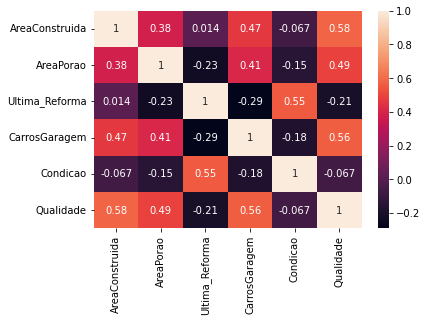

In [20]:
#Criando heatmap para verificação da colinearidade
sns.heatmap(base_alterada[["AreaConstruida","AreaPorao","Ultima_Reforma","CarrosGaragem","Condicao","Qualidade"]].corr(), annot=True)

In [21]:
#Variance Inflation Factor para verificar multicolinearidade entre as variáveis
vif = calc_vif(base_alterada[var_escolhidas])
print('vars: ', var_escolhidas)
print('Variable Inflation Factors:', vif.VIF.sum(), '\n')
vif

vars:  ['AreaConstruida', 'AreaPorao', 'Ultima_Reforma', 'CarrosGaragem', 'Condicao', 'Qualidade']
Variable Inflation Factors: 97.83204531842381 



,variables,VIF
0,AreaConstruida,16.931763
1,AreaPorao,10.528213
2,Ultima_Reforma,2.113803
3,CarrosGaragem,11.510602
4,Condicao,17.279173
5,Qualidade,39.468492


<h3>4.3 - Verificando distribuição dos resíduos para validação do modelo</h3>

A distribuição dos erros é relativamente homoscedástica e os resíduos têm distribuição com alto grau de normalidade

Text(0.61, 0.95, '(VIF: 97.83204531842381)')

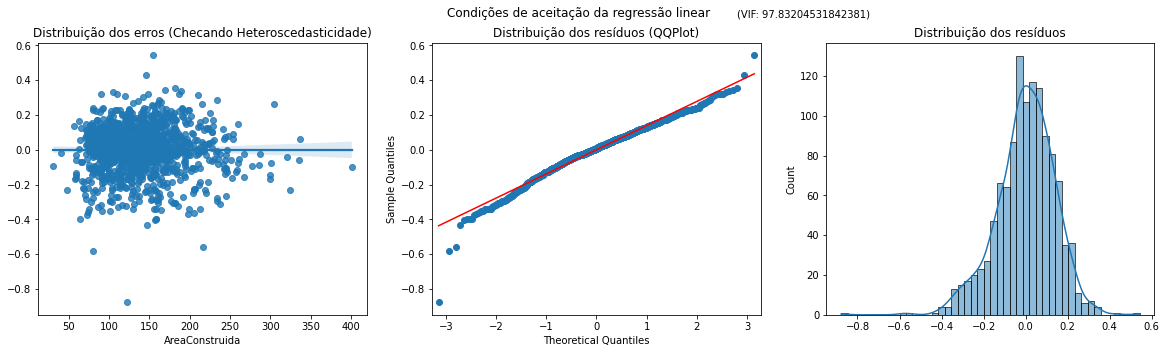

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(20,5), facecolor='white') 
splot1 = sns.regplot(x=base_alterada.AreaConstruida, y=model.resid, ax=axs[0])
splot2 = sm.qqplot(model.resid, line="s", ax=axs[1])
splot3 = sns.histplot(model.resid, kde=True, ax=axs[2])

axs[0].set_title('Distribuição dos erros (Checando Heteroscedasticidade)')
axs[1].set_title('Distribuição dos resíduos (QQPlot)')
axs[2].set_title('Distribuição dos resíduos')
fig.suptitle('Condições de aceitação da regressão linear')
fig.text(s='(VIF: {})'.format(vif.VIF.sum()), y=0.95, x=0.61)


<h3> 4.4 Interpretação do modelo de regressão linear </h3>

In [23]:
round((np.exp(model.params[1:]) - 1)*100, 2)

AreaConstruida     0.29
AreaPorao          0.22
Ultima_Reforma    -0.22
CarrosGaragem     10.13
Condicao           6.21
Qualidade         10.59
dtype: float64

O aumento de 1m² na área construída aumenta o preço da residência em 0.29%

O aumento de 1m² na área do porão aumenta o preço da residência em 0.22%

O aumento de 1 ano desde a última reforma diminui o preço da residência em 0.22%

O aumento de 1 carro no espaço da garagem aumenta o preço da residência em 10.13%

A melhoria de 1 grau de condição aumenta o preço da residência em 6.21%

A melhoria de 1 grau de qualidade aumenta o preço da residência em 10.59%

<h2>5 - Entendendo as variáveis mais importantes na predição do preço a partir de RandomForest</h2>

In [63]:
#Obtendo novamente as variáveis numéricas e categóricas do modelo

v_resposta = 'PrecoVenda'

#Lista das variáveis numéricas
v_numericos = base_alterada.select_dtypes(include=["int", "float"]).columns.to_list()
v_numericos.remove(v_resposta)

#Lista das variáveis categóricas
v_categoricas = base_alterada.select_dtypes(exclude=["int", "float"]).columns.to_list()

In [65]:
v_numericos.remove('logPrecoVenda')

<h3>5.1 - Criando os splits para treino, validação e teste do modelo</h3>

In [66]:
features = v_categoricas + v_numericos

(X_train, X_test, X_val,
y_train, y_test, y_val) = train_test_valid_split(base_alterada, features=features, target=v_resposta, test_size=0.3, valid_size=0.5, random_state=31)


In [68]:
def random_forest_preprocessing(X_train, X_val, X_test, y_train):

  # Categoricals pre-processing (categorical encoders)
  target_encoder = TargetEncoder()
  X_train[v_categoricas] = target_encoder.fit_transform(X_train[v_categoricas], y_train)
  X_val[v_categoricas] = target_encoder.transform(X_val[v_categoricas])
  X_test[v_categoricas] = target_encoder.transform(X_test[v_categoricas])

  return X_train, X_val, X_test

In [69]:
X_train, X_val, X_test = random_forest_preprocessing(X_train, X_val, X_test, y_train)

c:\Users\orise\AppData\Local\Programs\Python\Python39\lib\site-packages\category_encoders\target_encoder.py:122: FutureWarning:

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327

c:\Users\orise\AppData\Local\Programs\Python\Python39\lib\site-packages\category_encoders\target_encoder.py:127: FutureWarning:

Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327



<h3>5.2 Rodando o baseline do RandomForest</h3>

In [70]:
rf_baseline = RandomForestRegressor(random_state=42)
# Treino
rf_baseline.fit(X_train, y_train)

y_val_baseline_pred = rf_baseline.predict(X_val)
baseline_report = metrics_report(y_val, y_val_baseline_pred, 'validation')
baseline_report

,metric,validation
0,RMSE,22571.24
1,MAE,16066.07
2,R^2,0.88
3,MAPE,0.09
4,Avg. target,175268.56
5,Avg. Prediction,175890.72


<h3> 5.3 Descobrindo as melhores condições de alguns hiperparametros para o modelo </h3>

In [87]:
#Testando o número de estimadores (as árvores da floresta)

rmse_final = 0
n_estimators_final = 0

for n_estimator in [5, 10, 20, 40, 80, 120, 160, 200, 240]:
    print('número de estimadores: {}'.format(n_estimator))
    rf_model = RandomForestRegressor(n_estimators=n_estimator,random_state=42)
    rf_model.fit(X_train, y_train)
    y_val_model_pred = rf_model.predict(X_val)
    rmse = math.sqrt(mean_squared_error(y_val, y_val_model_pred))

    if (rmse_final == 0) or (rmse < rmse_final):
        rmse_final = rmse
        n_estimators_final = n_estimator

print('rmse: {}'.format(rmse_final) + ' melhor número de features: {}'.format(n_estimator))

número de estimadores: 5
número de estimadores: 10
número de estimadores: 20
número de estimadores: 40
número de estimadores: 80
número de estimadores: 120
número de estimadores: 160
número de estimadores: 200
número de estimadores: 240
rmse: 22573.93362369258 melhor número de features: 240


In [83]:
#Testando o número de features maximo (o tanto de variáveis do modelo que as árvores considerarão)

rmse_final = 0
n_features_final = 0

for max_feature in np.arange(0.1, 1, 0.05):
    print('número de features contabilizadas: {}'.format(max_feature))
    rf_model = RandomForestRegressor(max_features=max_feature,random_state=42)
    rf_model.fit(X_train, y_train)
    y_val_model_pred = rf_model.predict(X_val)
    rmse = math.sqrt(mean_squared_error(y_val, y_val_model_pred))

    if (rmse_final == 0) or (rmse < rmse_final):
        rmse_final = rmse
        n_features_final = max_feature

print('rmse: {}'.format(rmse_final) + ' melhor número de features: {}'.format(n_features_final))

número de features contabilizadas: 0.1
número de features contabilizadas: 0.15000000000000002
número de features contabilizadas: 0.20000000000000004
número de features contabilizadas: 0.25000000000000006
número de features contabilizadas: 0.30000000000000004
número de features contabilizadas: 0.3500000000000001
número de features contabilizadas: 0.40000000000000013
número de features contabilizadas: 0.45000000000000007
número de features contabilizadas: 0.5000000000000001
número de features contabilizadas: 0.5500000000000002
número de features contabilizadas: 0.6000000000000002
número de features contabilizadas: 0.6500000000000001
número de features contabilizadas: 0.7000000000000002
número de features contabilizadas: 0.7500000000000002
número de features contabilizadas: 0.8000000000000002
número de features contabilizadas: 0.8500000000000002
número de features contabilizadas: 0.9000000000000002
número de features contabilizadas: 0.9500000000000003
rmse: 19440.383380170846 melhor númer

<h3> 5.4 Criando modelo final com número ideal de features e estimadores </h3>

In [91]:
#Validação
rf_model_final = RandomForestRegressor(n_estimators=240, max_features=0.3)
rf_model_final.fit(X_train, y_train)
y_val_model_final = rf_model_final.predict(X_val)
baseline_report = metrics_report(y_val, y_val_model_final, 'validation')
baseline_report

,metric,validation
0,RMSE,20181.34
1,MAE,14344.08
2,R^2,0.90
3,MAPE,0.09
4,Avg. target,175268.56
5,Avg. Prediction,174789.17


In [93]:
#Teste
rf_model_final = RandomForestRegressor(n_estimators=240, max_features=0.3)
rf_model_final.fit(X_train, y_train)
y_test_model_final = rf_model_final.predict(X_test)
baseline_report = metrics_report(y_test, y_test_model_final, 'teste')
baseline_report

,metric,teste
0,RMSE,19624.17
1,MAE,13352.12
2,R^2,0.90
3,MAPE,0.09
4,Avg. target,169394.04
5,Avg. Prediction,170048.73


<h3> 5.5 Permutation Feature Importance para descobrir as features mais importantes </h3>

In [94]:
permutation_result = permutation_importance(rf_model_final, X_val, y_val, n_repeats=5)

In [96]:
df_importancia = pd.DataFrame({'column' : X_val.columns, 'importance': permutation_result.importances_mean})
df_importancia.sort_values(by='importance', ascending=False, inplace=True)


,column,importance
55,AreaConstruida,0.128364
42,Qualidade,0.125668
51,AreaPorao,0.037556
10,QualidadeCobertura,0.030949
67,AreaGaragem,0.024693
...,...,...
78,Banheiros_por_Quarto,-0.000259
60,BedroomAbvGr,-0.000328
54,BaixaQualiAreaAcab,-0.000373
11,CondicaoExterna,-0.000519


Text(0.5, 0.98, 'Variáveis mais importantes no entendimento dos valores de residências vendidas')

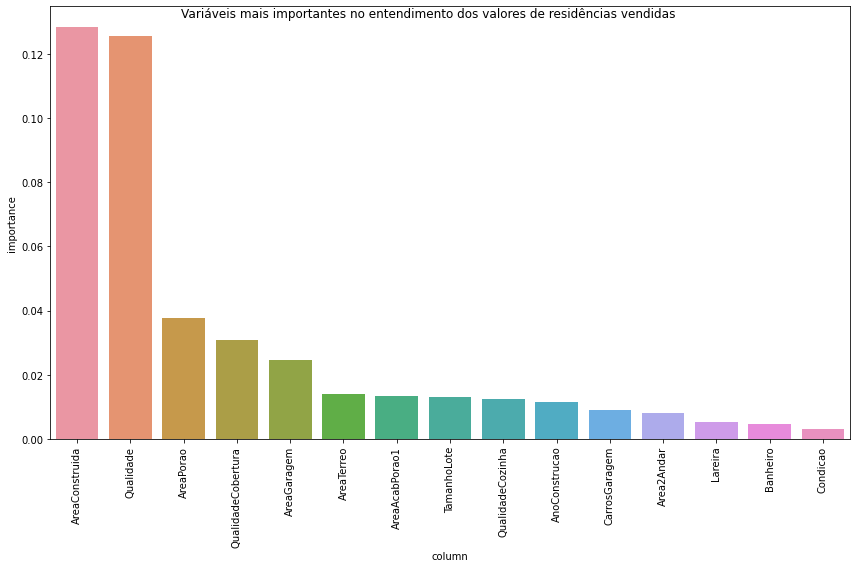

In [101]:
fig, axs = plt.subplots(figsize=(12,8), facecolor='white')
ax = sns.barplot(x='column', y="importance", data=df_importancia.nlargest(15, 'importance'))
plt.xticks(rotation=90)
plt.tight_layout()

fig.suptitle('Variáveis mais importantes no entendimento dos valores de residências vendidas')

A partir dos treinos e teste o modelo de machine learning indica que as duas variáveis mais importantes na predição dos valores das residências vendidas são a quantidade de área construída e a qualidade da habiração, juntas, essas variáveis explicam aproximadamente 1/4 do valor dos imóveis. As áreas referentes ao porão, à garagem e ao térreo do edifício também constituem parte importante dos valores, além da qualidade da cobertura.